In [5]:
# jax import 
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import bilby
import numpy as np

C = 299792458.0
G = 6.67408 * 1e-11
Mo = 1.989 * 1e30
Gamma = 0.5772156649015329
Pi = jnp.pi
MTSUN_SI = 4.925491025543576e-06

In [ ]:
from math import fmod
from bilby.core.utils import ra_dec_to_theta_phi

def greenwich_mean_sidereal_time(time):
    from lal import GreenwichMeanSiderealTime
    time = float(time)
    return GreenwichMeanSiderealTime(time)

In [1]:
from lal import GreenwichMeanSiderealTime

In [10]:
# GPS time 50 years from 1126259642.413

1576800000

In [100]:
# gps time from 2015 to 2050
time = np.linspace(1126259642.413, 1126259642.413+24*60*60*365, 1000)
gmst = []
for i in time:
    t_ = float(i)
    gmst.append(GreenwichMeanSiderealTime(t_))
gmst = np.array(gmst)

In [90]:
GreenwichMeanSiderealTime(1126259642.413)

36137.068361399164

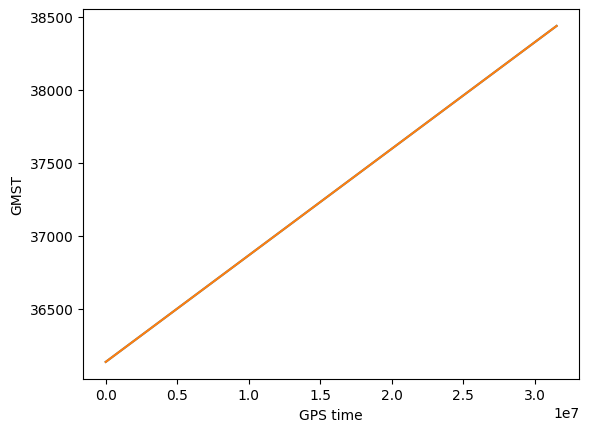

In [107]:
# plot the gmst
import matplotlib.pyplot as plt
x_ = np.linspace(0, 24*60*60*365, 1000)
plt.plot(time-time[0], gmst)
plt.plot(time-time[0], gps_to_gmst(time)) 
plt.xlabel('GPS time')
plt.ylabel('GMST')
plt.show()

In [97]:
x2 = 1126259642.413+24*60*60
x1 = 1126259642.413
y2 = GreenwichMeanSiderealTime(x2)
y1 = GreenwichMeanSiderealTime(x1)
slope = (y2-y1)/(x2-x1)
print(slope)

7.292115855382993e-05


In [156]:
@jit
def gps_to_gmst(gps_time):
    slope = 7.292115855382993e-05
    time0 = 1126259642.413
    time = gps_time - time0
    return slope*time+36137.068361399164

@jit
def ra_dec_to_theta_phi(ra, dec, gmst):
    phi = ra - gmst
    theta = jnp.pi / 2.0 - dec
    return theta, phi

In [181]:
# define values
time = 1126259642.413
ra = 1.375
dec = -1.2108
psi = 0.1
mode = "plus"
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
detector_tensor = ifos[0].detector_tensor


In [182]:
@jit
def get_polarization_tensor(ra, dec, time, psi):
    gmst = jnp.fmod(gps_to_gmst(time), 2 * jnp.pi)
    theta, phi = ra_dec_to_theta_phi(ra, dec, gmst)
    u = jnp.array([jnp.cos(phi) * jnp.cos(theta), jnp.cos(theta) * jnp.sin(phi), -jnp.sin(theta)])
    v = jnp.array([-jnp.sin(phi), jnp.cos(phi), 0])
    m = -u * jnp.sin(psi) - v * jnp.cos(psi)
    n = -u * jnp.cos(psi) + v * jnp.sin(psi)

    return jnp.einsum('i,j->ij', m, m) - jnp.einsum('i,j->ij', n, n)

@jit
def antenna_response(ra, dec, time, psi, detector_tensor):

    polarization_tensor = get_polarization_tensor(ra, dec, time, psi)
    return jnp.einsum('ij,ij->', detector_tensor, polarization_tensor)

In [183]:
antenna_response(ra, dec, time, psi, jnp.array(detector_tensor))

Array(-0.19871911, dtype=float32)

In [185]:
gmst = jnp.fmod(gps_to_gmst(time), 2 * jnp.pi)
theta, phi = ra_dec_to_theta_phi(ra, dec, gmst)
u = jnp.array([jnp.cos(phi) * jnp.cos(theta), jnp.cos(theta) * jnp.sin(phi), -jnp.sin(theta)])
v = jnp.array([-jnp.sin(phi), jnp.cos(phi), 0])
m = -u * jnp.sin(psi) - v * jnp.cos(psi)
n = -u * jnp.cos(psi) + v * jnp.sin(psi)

In [195]:
np.shape(np.array([m]))

(1, 3)

In [198]:
@jit
def einsum1(m,n):
    ans = jnp.zeros((3,3))
    ans[0,0] = m[0]*n[0]
    ans[0,1] = m[0]*n[1]
    ans[0,2] = m[0]*n[2]
    ans[1,0] = m[1]*n[0]
    ans[1,1] = m[1]*n[1]
    ans[1,2] = m[1]*n[2]
    ans[2,0] = m[2]*n[0]
    ans[2,1] = m[2]*n[1]
    ans[2,2] = m[2]*n[2]
    return ans
@jit
def einsum2(m,n):
    ans = m[0,0]*n[0,0] + m[0,1]*n[0,1] + m[0,2]*n[0,2] + m[1,0]*n[1,0] + m[1,1]*n[1,1] + m[1,2]*n[1,2] + m[2,0]*n[2,0] + m[2,1]*n[2,1] + m[2,2]*n[2,2]
    return ans

In [190]:
print(-0.8420163*-0.8420163)
print(-0.8420163*-0.53830457)
print(-0.8420163*0.03516839)
print(-0.8420163*-0.53830457)

0.70899144946569
0.453261222304491
-0.029612357624757002
0.453261222304491


In [187]:
jnp.einsum('i,j->ij', m, m)

Array([[ 0.7089914 ,  0.4532612 , -0.02961235],
       [ 0.4532612 ,  0.2897718 , -0.0189313 ],
       [-0.02961235, -0.0189313 ,  0.00123682]], dtype=float32)

In [160]:
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])

In [199]:
# randor ra and dec
# ra = np.random.uniform(0, 2*np.pi)
# dec = np.random.uniform(-np.pi/2, np.pi/2)
ifos[0].antenna_response(ra, dec, time, psi, 'cross')

0.5911086754149112

In [ ]:
gmst = jnp.fmod(gps_to_gmst(time), 2 * jnp.pi)
theta, phi = ra_dec_to_theta_phi(ra, dec, gmst)
jnp.array([jnp.cos(phi) * jnp.cos(theta), jnp.cos(theta) * jnp.sin(phi), -jnp.sin(theta)])

In [136]:
def greenwich_mean_sidereal_time(time):
    from lal import GreenwichMeanSiderealTime
    time = float(time)
    return GreenwichMeanSiderealTime(time)

def ra_dec_to_theta_phi(ra, dec, gmst):
    phi = ra - gmst
    theta = np.pi / 2.0 - dec
    return theta, phi

def get_polarization_tensor(ra, dec, time, psi, mode):

    gmst = fmod(greenwich_mean_sidereal_time(time), 2 * np.pi)
    theta, phi = ra_dec_to_theta_phi(ra, dec, gmst)
    u = np.array([np.cos(phi) * np.cos(theta), np.cos(theta) * np.sin(phi), -np.sin(theta)])
    v = np.array([-np.sin(phi), np.cos(phi), 0])
    m = -u * np.sin(psi) - v * np.cos(psi)
    n = -u * np.cos(psi) + v * np.sin(psi)

    if mode.lower() == 'plus':
        return np.einsum('i,j->ij', m, m) - np.einsum('i,j->ij', n, n)
    elif mode.lower() == 'cross':
        return np.einsum('i,j->ij', m, n) + np.einsum('i,j->ij', n, m)
    elif mode.lower() == 'breathing':
        return np.einsum('i,j->ij', m, m) + np.einsum('i,j->ij', n, n)

    # Calculating omega here to avoid calculation when model in [plus, cross, breathing]
    omega = np.cross(m, n)
    if mode.lower() == 'longitudinal':
        return np.einsum('i,j->ij', omega, omega)
    elif mode.lower() == 'x':
        return np.einsum('i,j->ij', m, omega) + np.einsum('i,j->ij', omega, m)
    elif mode.lower() == 'y':
        return np.einsum('i,j->ij', n, omega) + np.einsum('i,j->ij', omega, n)
    else:
        raise ValueError("{} not a polarization mode!".format(mode))

In [115]:
greenwich_mean_sidereal_time(1126259642.413)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
The problem arose with the `float` function. If trying to convert the data type of a value, try using `x.astype(float)` or `jnp.array(x, float)` instead.
The error occurred while tracing the function greenwich_mean_sidereal_time at /var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_40273/2180254075.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument time.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [116]:
10e-3*100000/3600

0.2777777777777778